# Model

- [x] data augmentation with grid
- [x] split train test with uscs clusters
- [x] predict uscs and sptn
- [x] first predict uscs with one table, then predict sptn with another
- [x] try different models
- [ ] give accuracy vs distance/#boreholes within a region
- [ ] predict an array of test elevation of one borehole
- [ ] cross validation if necessary

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('../data/boreholes_uscs_sptn.csv')
df

,Borehole ID,Latitude,Longitude,Elevation (ft),In-situ Test #,Test Elevation (ft),SPTN,Layer #,Layer Top Elevation (ft),Layer Bottom Elevation (ft),Soil Description,Lithology,USCS,Density / Consistency
0,21,47.568436,-122.407480,77.30,1,77.30,3.0,1,77.30,75.80,"Grayish brown, dry, very loose, well graded sa...",Fill,Fill,NaN
1,21,47.568436,-122.407480,77.30,2,75.80,12.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Stiff
2,21,47.568436,-122.407480,77.30,3,74.30,8.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Medium
3,21,47.568436,-122.407480,77.30,4,73.30,7.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Medium
4,21,47.568436,-122.407480,77.30,5,71.80,7.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19711,153205,47.437412,-122.242456,23.75,9,-8.75,44.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Dense
19712,153205,47.437412,-122.242456,23.75,10,-13.75,23.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Medium
19713,153205,47.437412,-122.242456,23.75,11,-18.75,43.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Dense
19714,153205,47.437412,-122.242456,23.75,12,-23.75,27.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Dense


In [4]:
df['USCS'].unique()

array(['Fill', 'CH', 'ML', 'SW', 'SM', 'incorrect', 'Asphalt or concrete',
       'SC', 'PT', 'SP', 'CL', 'Topsoil or vegetation', 'OL', 'GW', 'OH',
       'GM', 'MH', 'GP', 'GC', 'Bedrock', 'Volcanic ash'], dtype=object)

In [5]:
table_uscs = pd.read_csv('../data/file_2_reUSCS_sampling_with_elevation.csv')
table_uscs

,Borehole ID,Document ID,Latitude,Longitude,Elevation,Sampling Depth,Sampling Elevation,USCS
0,1,342,47.574251,-122.407051,148.80,0.600000,148.200000,Fill
1,1,342,47.574251,-122.407051,148.80,1.950000,146.850000,ML
2,1,342,47.574251,-122.407051,148.80,5.350000,143.450000,ML
3,2,342,47.574177,-122.407057,149.50,0.400000,149.100000,Topsoil or vegetation
4,2,342,47.574177,-122.407057,149.50,1.650000,147.850000,SM
...,...,...,...,...,...,...,...,...
391305,153210,66313,47.437303,-122.243141,24.02,22.666667,1.353333,SM
391306,153210,66313,47.437303,-122.243141,24.02,26.333333,-2.313333,SM
391307,153211,66313,47.437099,-122.242644,25.40,4.000000,21.400000,SM
391308,153211,66313,47.437099,-122.242644,25.40,13.000000,12.400000,SM


In [6]:
table_uscs['USCS'].unique()

array(['Fill', 'ML', 'Topsoil or vegetation', 'SM', 'CL', 'CH', 'SC',
       'SW', 'GW', 'SP', 'OH', 'Asphalt or concrete', 'PT', 'OL', 'GM',
       'Bedrock', 'GC', 'GP', 'MH', 'Volcanic ash'], dtype=object)

## Split train-test based on borehole clusters

ie. Cluster some nearby boreholes.
For boreholes that are very close, they can either be in train or in the test.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split

In [8]:
# Drop rows with missing coordinates
df_clean = df.dropna(subset=["Latitude", "Longitude", "Test Elevation (ft)"]).copy()

# Compute borehole-level coordinates
borehole_coords = df_clean.groupby("Borehole ID")[["Latitude", "Longitude"]].mean()

# Use DBSCAN to cluster nearby boreholes (eps in degrees, approx. ~0.001 ~ 100m)
dbscan = DBSCAN(eps=0.0015, min_samples=1)
borehole_coords["cluster"] = dbscan.fit_predict(borehole_coords[["Latitude", "Longitude"]])

# Map each borehole to a cluster
borehole_cluster_map = borehole_coords["cluster"].to_dict()
df_clean["cluster"] = df_clean["Borehole ID"].map(borehole_cluster_map)

# Split clusters into train/test
unique_clusters = df_clean["cluster"].unique()
train_clusters, test_clusters = train_test_split(unique_clusters, test_size=0.2, random_state=42)

# Assign train/test set based on cluster
df_clean["set"] = df_clean["cluster"].apply(lambda x: "train" if x in train_clusters else "test")

# Check cluster count and assignments
df_clean["set"].value_counts(), df_clean["cluster"].nunique()


(set
 train    15638
 test      3094
 Name: count, dtype: int64,
 811)

In [9]:
unique_clusters

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [10]:
df_clean

,Borehole ID,Latitude,Longitude,Elevation (ft),In-situ Test #,Test Elevation (ft),SPTN,Layer #,Layer Top Elevation (ft),Layer Bottom Elevation (ft),Soil Description,Lithology,USCS,Density / Consistency,cluster,set
0,21,47.568436,-122.407480,77.30,1,77.30,3.0,1,77.30,75.80,"Grayish brown, dry, very loose, well graded sa...",Fill,Fill,NaN,0,train
1,21,47.568436,-122.407480,77.30,2,75.80,12.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Stiff,0,train
2,21,47.568436,-122.407480,77.30,3,74.30,8.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Medium,0,train
3,21,47.568436,-122.407480,77.30,4,73.30,7.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Medium,0,train
4,21,47.568436,-122.407480,77.30,5,71.80,7.0,2,75.80,70.30,"Clay, medium gray, stiff, slightly moist, with...",Clay,CH,Medium,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19711,153205,47.437412,-122.242456,23.75,9,-8.75,44.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Dense,810,train
19712,153205,47.437412,-122.242456,23.75,10,-13.75,23.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Medium,810,train
19713,153205,47.437412,-122.242456,23.75,11,-18.75,43.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Dense,810,train
19714,153205,47.437412,-122.242456,23.75,12,-23.75,27.0,6,-3.25,-30.25,"Dark gray silty fine to medium sand, loose bec...",Silty sand,SM,Dense,810,train


In [11]:
# Drop rows with missing coordinates
df_clean2 = table_uscs.dropna(subset=["Latitude", "Longitude", "Sampling Elevation"]).copy()

# Compute borehole-level coordinates
borehole_coords2 = df_clean2.groupby("Borehole ID")[["Latitude", "Longitude"]].mean()

# Use DBSCAN to cluster nearby boreholes (eps in degrees, approx. ~0.001 ~ 100m)
dbscan2 = DBSCAN(eps=0.0015, min_samples=1)
borehole_coords2["cluster"] = dbscan.fit_predict(borehole_coords2[["Latitude", "Longitude"]])

# Map each borehole to a cluster
borehole_cluster_map2 = borehole_coords2["cluster"].to_dict()
df_clean2["cluster"] = df_clean2["Borehole ID"].map(borehole_cluster_map2)

# Split clusters into train/test
unique_clusters2 = df_clean2["cluster"].unique()
train_clusters2, test_clusters2 = train_test_split(unique_clusters2, test_size=0.2, random_state=42)

# Assign train/test set based on cluster
df_clean2["set"] = df_clean2["cluster"].apply(lambda x: "train" if x in train_clusters2 else "test")

# Check cluster count and assignments
df_clean2["set"].value_counts(), df_clean2["cluster"].nunique()


(set
 train    345511
 test      44573
 Name: count, dtype: int64,
 5066)

In [12]:
unique_clusters2[-1]

np.int64(5065)

## Train

# Baseline: logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Separate datasets for classification (USCS)
df_uscs = df_clean2.dropna(subset=['USCS']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Sampling Elevation', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Train Logistic Regression Classifier
clf_logistic = LogisticRegression(max_iter=1000, random_state=42)
clf_logistic.fit(X_train_uscs, y_train_uscs)

# Predict and evaluate
y_pred_uscs_logistic = clf_logistic.predict(X_test_uscs)
accuracy_uscs_logistic = accuracy_score(y_test_uscs, y_pred_uscs_logistic)

accuracy_uscs_logistic


/Users/mac/Documents/699/Mpera-Soillense/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4440131918425953

### Random forest

Here, we use df to train and test both uscs and sptn

In [13]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error

In [15]:
# Separate datasets for classification (USCS) and regression (SPTN)
df_uscs = df_clean.dropna(subset=['USCS']).copy()
df_sptn = df_clean.dropna(subset=['SPTN']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Test Elevation (ft)', 'Elevation (ft)', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Regression: SPTN
X_train_sptn = df_sptn[df_sptn['set'] == 'train'][features]
y_train_sptn = df_sptn[df_sptn['set'] == 'train']['SPTN']
X_test_sptn = df_sptn[df_sptn['set'] == 'test'][features]
y_test_sptn = df_sptn[df_sptn['set'] == 'test']['SPTN']

# Train Random Forest Classifier for USCS
clf_uscs = RandomForestClassifier(n_estimators=100, random_state=42)
clf_uscs.fit(X_train_uscs, y_train_uscs)
y_pred_uscs = clf_uscs.predict(X_test_uscs)
accuracy_uscs = accuracy_score(y_test_uscs, y_pred_uscs)

# Train Random Forest Regressor for SPTN
reg_sptn = RandomForestRegressor(n_estimators=100, random_state=42)
reg_sptn.fit(X_train_sptn, y_train_sptn)
y_pred_sptn = reg_sptn.predict(X_test_sptn)
mae_sptn = mean_absolute_error(y_test_sptn, y_pred_sptn)

accuracy_uscs, mae_sptn

(0.2727860374919198, 21.418128158955888)

Here we first predict uscs on table_uscs

In [16]:
table_uscs['USCS'].unique()

array(['Fill', 'ML', 'Topsoil or vegetation', 'SM', 'CL', 'CH', 'SC',
       'SW', 'GW', 'SP', 'OH', 'Asphalt or concrete', 'PT', 'OL', 'GM',
       'Bedrock', 'GC', 'GP', 'MH', 'Volcanic ash'], dtype=object)

In [17]:
# Separate datasets for classification (USCS) and regression (SPTN)
df_uscs = df_clean2.dropna(subset=['USCS']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Elevation', 'Sampling Elevation', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Train Random Forest Classifier for USCS
clf_uscs = RandomForestClassifier(n_estimators=100, random_state=42)
clf_uscs.fit(X_train_uscs, y_train_uscs)
y_pred_uscs = clf_uscs.predict(X_test_uscs)
accuracy_uscs = accuracy_score(y_test_uscs, y_pred_uscs)

accuracy_uscs

0.4307989141408476

### Gradiant Boosting

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Separate datasets for classification (USCS)
df_uscs = df_clean2.dropna(subset=['USCS']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Sampling Elevation', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Train Gradient Boosting Classifier for USCS
clf_gb = GradientBoostingClassifier(n_estimators=50, max_depth=3, random_state=42)
clf_gb.fit(X_train_uscs, y_train_uscs)

# Predict and evaluate the accuracy
y_pred_uscs_gb = clf_gb.predict(X_test_uscs)
accuracy_uscs_gb = accuracy_score(y_test_uscs, y_pred_uscs_gb)

accuracy_uscs_gb


0.32068741166176834

### Support Vector Machines (SVM)

In [19]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Separate datasets for classification (USCS)
df_uscs = df_clean2.dropna(subset=['USCS']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Sampling Elevation', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Train SVM Classifier for USCS
clf_svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
clf_svm.fit(X_train_uscs, y_train_uscs)

# Predict and evaluate the accuracy
y_pred_uscs_svm = clf_svm.predict(X_test_uscs)
accuracy_uscs_svm = accuracy_score(y_test_uscs, y_pred_uscs_svm)

accuracy_uscs_svm


0.4372153545868575

### Neural Networks (MLPClassifier)

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Separate datasets for classification (USCS)
df_uscs = df_clean2.dropna(subset=['USCS']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Sampling Elevation', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Train MLP Classifier for USCS
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
clf_mlp.fit(X_train_uscs, y_train_uscs)

# Predict and evaluate the accuracy
y_pred_uscs_mlp = clf_mlp.predict(X_test_uscs)
accuracy_uscs_mlp = accuracy_score(y_test_uscs, y_pred_uscs_mlp)

accuracy_uscs_mlp


0.4465707939784174

# Evaluation

/var/folders/j3/ysrvtscj0nq0ms81ysfz94bh0000gn/T/ipykernel_18842/2838786368.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = df_test.groupby("distance_bin_km")["correct"].mean().reset_index()


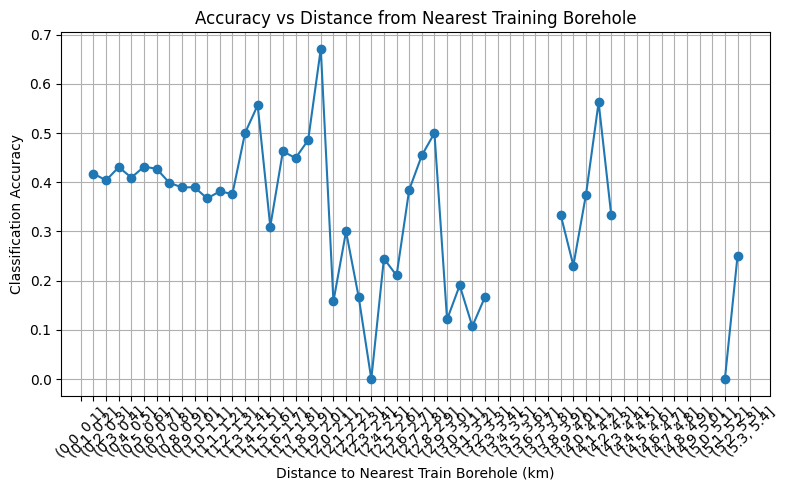

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

# Load your CSV
df = pd.read_csv("../data/file_2_reUSCS_sampling_with_elevation.csv")

# Clean missing values
df_clean = df.dropna(subset=["Latitude", "Longitude", "Sampling Elevation"]).copy()

# Cluster boreholes
borehole_coords = df_clean.groupby("Borehole ID")[["Latitude", "Longitude"]].mean()
dbscan = DBSCAN(eps=0.0015, min_samples=1)
borehole_coords["cluster"] = dbscan.fit_predict(borehole_coords[["Latitude", "Longitude"]])
df_clean["cluster"] = df_clean["Borehole ID"].map(borehole_coords["cluster"])

# Train-test split by cluster
train_clusters, test_clusters = train_test_split(df_clean["cluster"].unique(), test_size=0.2, random_state=42)
df_clean["set"] = df_clean["cluster"].apply(lambda x: "train" if x in train_clusters else "test")
df_clean["USCS_encoded"] = df_clean["USCS"].astype("category").cat.codes

# Features
features = ["Sampling Elevation", "Latitude", "Longitude"]
X_train = df_clean[df_clean["set"] == "train"][features]
y_train = df_clean[df_clean["set"] == "train"]["USCS_encoded"]
X_test = df_clean[df_clean["set"] == "test"][features]
y_test = df_clean[df_clean["set"] == "test"]["USCS_encoded"]

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Distance to nearest train borehole
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train[["Latitude", "Longitude"]])
distances, _ = nn.kneighbors(X_test[["Latitude", "Longitude"]])
distances_km = distances.flatten() * 111

# Accuracy binning
df_test = df_clean[df_clean["set"] == "test"].copy()
df_test["correct"] = (y_pred == y_test.values)
df_test["distance_km"] = distances_km
df_test["distance_bin_km"] = pd.cut(df_test["distance_km"], bins=np.arange(0, 5.5, 0.1))
bin_accuracy = df_test.groupby("distance_bin_km")["correct"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_accuracy["distance_bin_km"].astype(str), bin_accuracy["correct"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Distance to Nearest Train Borehole (km)")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy vs Distance from Nearest Training Borehole")
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/j3/ysrvtscj0nq0ms81ysfz94bh0000gn/T/ipykernel_18842/510690784.py:46: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_accuracy = test_df.groupby("distance_bin_km")["correct"].mean().reset_index()


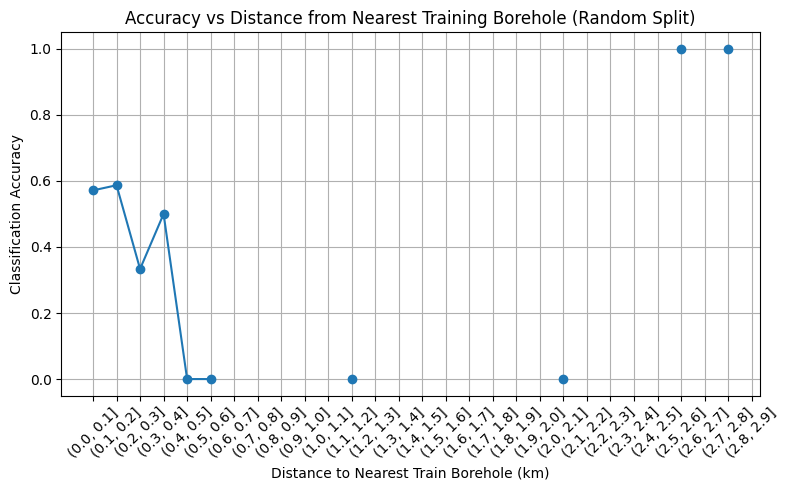

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

# Load the CSV
df = pd.read_csv("../data/file_2_reUSCS_sampling_with_elevation.csv")

# Drop missing values
df_clean = df.dropna(subset=["Latitude", "Longitude", "Sampling Elevation"]).copy()

# Encode USCS
df_clean["USCS_encoded"] = df_clean["USCS"].astype("category").cat.codes

# Random train-test split
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

# Features and labels
features = ["Sampling Elevation", "Latitude", "Longitude"]
X_train = train_df[features]
y_train = train_df["USCS_encoded"]
X_test = test_df[features]
y_test = test_df["USCS_encoded"]

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Distance to nearest training borehole
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train[["Latitude", "Longitude"]])
distances, _ = nn.kneighbors(X_test[["Latitude", "Longitude"]])
distances_km = distances.flatten() * 111  # degrees to km

# Annotate test set
test_df = test_df.copy()
test_df["correct"] = (y_pred == y_test.values)
test_df["distance_km"] = distances_km
test_df["distance_bin_km"] = pd.cut(test_df["distance_km"], bins=np.arange(0, 5.5, 0.1))

# Accuracy per distance bin
bin_accuracy = test_df.groupby("distance_bin_km")["correct"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_accuracy["distance_bin_km"].astype(str), bin_accuracy["correct"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Distance to Nearest Train Borehole (km)")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy vs Distance from Nearest Training Borehole (Random Split)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score

# Load your CSV
df = pd.read_csv("../data/boreholes_uscs_sptn.csv")

# Clean missing values
df_clean = df.dropna(subset=["Latitude", "Longitude", "Test Elevation (ft)"]).copy()

# Cluster boreholes
borehole_coords = df_clean.groupby("Borehole ID")[["Latitude", "Longitude"]].mean()
dbscan = DBSCAN(eps=0.0015, min_samples=1)
borehole_coords["cluster"] = dbscan.fit_predict(borehole_coords[["Latitude", "Longitude"]])
df_clean["cluster"] = df_clean["Borehole ID"].map(borehole_coords["cluster"])

# Train-test split by cluster
train_clusters, test_clusters = train_test_split(df_clean["cluster"].unique(), test_size=0.2, random_state=42)
df_clean["set"] = df_clean["cluster"].apply(lambda x: "train" if x in train_clusters else "test")
df_clean["USCS_encoded"] = df_clean["USCS"].astype("category").cat.codes

# Features
features = ["Test Elevation (ft)", "Latitude", "Longitude"]
X_train = df_clean[df_clean["set"] == "train"][features]
y_train = df_clean[df_clean["set"] == "train"]["USCS_encoded"]
X_test = df_clean[df_clean["set"] == "test"][features]
y_test = df_clean[df_clean["set"] == "test"]["USCS_encoded"]

# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Distance to nearest train borehole
nn = NearestNeighbors(n_neighbors=1)
nn.fit(X_train[["Latitude", "Longitude"]])
distances, _ = nn.kneighbors(X_test[["Latitude", "Longitude"]])
distances_km = distances.flatten() * 111

# Accuracy binning
df_test = df_clean[df_clean["set"] == "test"].copy()
df_test["correct"] = (y_pred == y_test.values)
df_test["distance_km"] = distances_km
df_test["distance_bin_km"] = pd.cut(df_test["distance_km"], bins=np.arange(0, 5.5, 0.1))
bin_accuracy = df_test.groupby("distance_bin_km")["correct"].mean().reset_index()

# Plot
plt.figure(figsize=(8, 5))
plt.plot(bin_accuracy["distance_bin_km"].astype(str), bin_accuracy["correct"], marker='o')
plt.xticks(rotation=45)
plt.xlabel("Distance to Nearest Train Borehole (km)")
plt.ylabel("Classification Accuracy")
plt.title("Accuracy vs Distance from Nearest Training Borehole")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv("../data/boreholes_uscs_sptn.csv")

# Separate datasets for classification (USCS)
df_uscs = df.dropna(subset=['USCS']).copy()

# Encode the USCS categorical target variable
df_uscs['USCS_encoded'] = df_uscs['USCS'].astype('category').cat.codes

# Define features
features = ['Test Elevation', 'Latitude', 'Longitude']

# Classification: USCS
X_train_uscs = df_uscs[df_uscs['set'] == 'train'][features]
y_train_uscs = df_uscs[df_uscs['set'] == 'train']['USCS_encoded']
X_test_uscs = df_uscs[df_uscs['set'] == 'test'][features]
y_test_uscs = df_uscs[df_uscs['set'] == 'test']['USCS_encoded']

# Train MLP Classifier for USCS
clf_mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
clf_mlp.fit(X_train_uscs, y_train_uscs)

# Predict and evaluate the accuracy
y_pred_uscs_mlp = clf_mlp.predict(X_test_uscs)
accuracy_uscs_mlp = accuracy_score(y_test_uscs, y_pred_uscs_mlp)

accuracy_uscs_mlp


/Users/mac/Documents/699/Mpera-Soillense/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/mac/Documents/699/Mpera-Soillense/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/mac/Documents/699/Mpera-Soillense/.venv/lib/python3.11/site-packages/sklearn/metrics/_classif

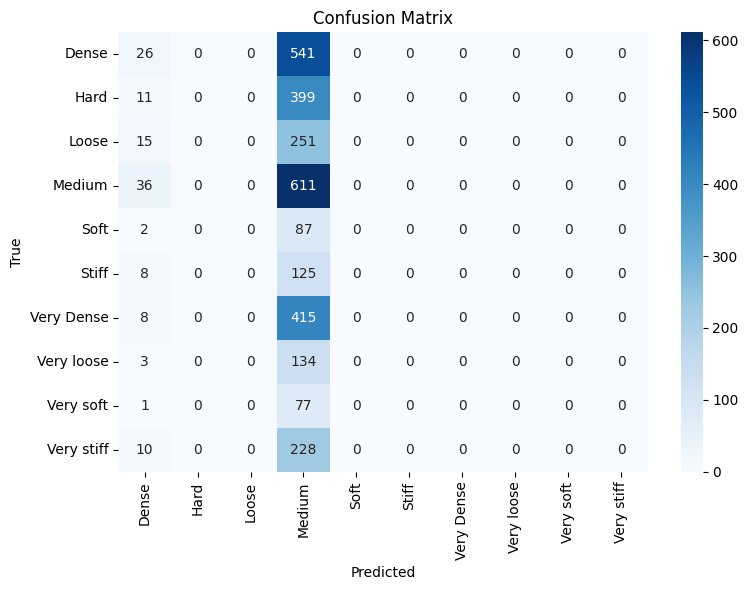

'              precision    recall  f1-score   support\n\n       Dense       0.22      0.05      0.08       567\n        Hard       0.00      0.00      0.00       410\n       Loose       0.00      0.00      0.00       266\n      Medium       0.21      0.94      0.35       647\n        Soft       0.00      0.00      0.00        89\n       Stiff       0.00      0.00      0.00       133\n  Very Dense       0.00      0.00      0.00       423\n  Very loose       0.00      0.00      0.00       137\n   Very soft       0.00      0.00      0.00        78\n  Very stiff       0.00      0.00      0.00       238\n\n    accuracy                           0.21      2988\n   macro avg       0.04      0.10      0.04      2988\nweighted avg       0.09      0.21      0.09      2988\n'

In [6]:
# Drop rows with missing values in selected features or the target
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/boreholes_uscs_sptn.csv")

df_clean = df.dropna(subset=['Density / Consistency', 'Latitude', 'Longitude', 'Test Elevation (ft)']).copy()

# Encode the target
label_encoder = LabelEncoder()
df_clean['DensityEncoded'] = label_encoder.fit_transform(df_clean['Density / Consistency'])

# Prepare features and labels
X = df_clean[['Latitude', 'Longitude', 'Test Elevation (ft)']]
y = df_clean['DensityEncoded']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
conf_matrix = confusion_matrix(y_test, y_pred)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

report


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

